In [37]:
import networkx as nx
import random
import copy
from tqdm.notebook import tqdm

## Create

In [38]:
amazon_G = nx.read_graphml('./amazon_graph.graphml')

# Minimizar la distancia entre los nodos dentro de una comunidad
# Maximizar la distancia entre los nodos de disintas comunidades

In [39]:
def create_individuo(nodes_of_graph, adj_matrix, transformation):
    individuo =  [None] * len(nodes_of_graph)
    for i in range(len(nodes_of_graph)): #el individuo creado con el tipo locus tiene la longitud de los nodos

        
        nodo_vecino = random.choice(range(len(adj_matrix[i]))) #la matriz de adyacencia tiene los nodos vecinos, los nodos vecinos hay que convertirlos a numeros
        while adj_matrix[i][nodo_vecino] == 0 and nodo_vecino != i:
            nodo_vecino = random.choice(range(len(adj_matrix[nodo_vecino])))
        
        
        keys = list(transformation.keys())
        values = list(transformation.values())
        individuo[i] = keys[values.index(nodo_vecino)] # en el gen se pone el aleatorio de los vecinos pero transformado en el indice que le corresponde 
    return individuo

def create(nodes_of_graph, adj_matrix, transformation, N=100): # crea población, la transformacion debe de ser del tipo { numero_de_nodo_real : indice_del_array}, donde el indice del array va de 0 a len(nodos) - 1
    new_population = []
    for individuo in range(N):
        new_population.append(create_individuo(nodes_of_graph, adj_matrix, transformation))
    
    return new_population

In [40]:
conversiones = {}
for i, nodo in enumerate(amazon_G.nodes):
    conversiones[nodo] = i
print(conversiones)

{'75780': 0, '317458': 1, '186386': 2, '419862': 3, '176159': 4, '204831': 5, '104481': 6, '57383': 7, '401449': 8, '299055': 9, '176184': 10, '542780': 11, '366654': 12, '124992': 13, '16457': 14, '196682': 15, '546890': 16, '546891': 17, '34895': 18, '321619': 19, '112724': 20, '276567': 21, '55386': 22, '374874': 23, '55388': 24, '221281': 25, '432229': 26, '104553': 27, '383087': 28, '335987': 29, '448649': 30, '522378': 31, '59532': 32, '491667': 33, '518306': 34, '309411': 35, '182435': 36, '204966': 37, '532649': 38, '544939': 39, '542899': 40, '172218': 41, '270524': 42, '250046': 43, '204991': 44, '231620': 45, '497867': 46, '186575': 47, '346322': 48, '399572': 49, '276695': 50, '530647': 51, '18650': 52, '252125': 53, '59613': 54, '127199': 55, '379102': 56, '159972': 57, '366824': 58, '116969': 59, '202986': 60, '430314': 61, '350442': 62, '4328': 63, '458993': 64, '30962': 65, '35067': 66, '57600': 67, '217346': 68, '295177': 69, '49424': 70, '278': 71, '123159': 72, '3218

In [41]:
A = nx.to_numpy_array(amazon_G)

In [42]:
pop = create(amazon_G.nodes, A, conversiones)

## Fitness

In [43]:
def convert_individuo(individuo_raw, conversiones):
    new_individuo = [None] * len(individuo_raw)
    for i in range(len(individuo_raw)):
        new_individuo[i] = conversiones.get(str(individuo_raw[i]))
    
    return new_individuo
def unconvert_individuo(individuo, conversiones):
    individuo_raw =  [None] * len(individuo)
    keys = list(conversiones.keys())
    values = list(conversiones.values())
    for i in range(len(individuo)):
        individuo_raw[i] = keys[values.index(individuo[i])]
    return individuo_raw

def get_comunidades(individuo):

    G = nx.Graph()

    for i in range(len(individuo)):
        G.add_edge(i, individuo[i])

    comunidades = list(nx.connected_components(G))
    return comunidades

def get_cs(aristas_of_min_one_node_in_comunity, nodos_de_la_comunidad):
    cs = 0
    for aristas in aristas_of_min_one_node_in_comunity:
        if aristas[0] in nodos_de_la_comunidad and aristas[1] not in nodos_de_la_comunidad:
            cs += 1
            
        #elif aristas[1] in nodos_de_la_comunidad and aristas[0] not in nodos_de_la_comunidad:
        #    cs += 1
    return cs

def get_ms(aristas_of_min_one_node_in_comunity, nodos_de_la_comunidad):
    ms = 0
    for aristas in aristas_of_min_one_node_in_comunity:
        if aristas[0] in nodos_de_la_comunidad and aristas[1] in nodos_de_la_comunidad:
            ms += 1
            
        
    return ms

In [44]:
def fit_conductance(grafo,individuo,conversiones):
    conductance = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        for nodo_of_comunity in comunidad_desconvertida:

            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        ms_community = get_ms(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        conductance += cs_community / (2*ms_community + cs_community)
        #
    
    return conductance
        
        
def fit_expansion(grafo,individuo,conversiones):
    expansion = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        for nodo_of_comunity in comunidad_desconvertida:

            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        ns_community = len(comunidad_desconvertida)
        expansion += cs_community / ns_community
        #
    
    return expansion


def fit_average_odf(grafo,individuo,conversiones):
    average_odf = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        sum_nodos = 0
        for nodo_of_comunity in comunidad_desconvertida:
            aristas_del_nodo = list(grafo.edges(str(nodo_of_comunity)))[0]
            
            sum_nodos += get_cs(aristas_del_nodo,nodo_of_comunity) / len(aristas_del_nodo)
            #aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        average_odf += sum_nodos / len(comunidad)
        
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        
        #
    
    return average_odf

def fit_Q(grafo,individuo,conversiones):
    Q = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        n_aristas = 0
        for nodo_of_comunity in comunidad_desconvertida:
            n_aristas += len(list(grafo.edges(str(nodo_of_comunity)))[0])
            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        
        ms_community = get_ms(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        
        Q += ((ms_community/n_aristas) - (((ms_community + cs_community)/(2*n_aristas))**2))
    
    return Q

## Select, Mutate y Crossover

In [45]:
def select (pop, fits, T): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
    seleccionados = random.sample(pop, T) #los 3 aleatorios
    for i, indiv in enumerate(seleccionados):
        es_dominante = True
        for j, indiv2 in enumerate(seleccionados): 
            if i == j:
                continue
            
            if fits[i][0] > fits[j][0] and fits[i][1] > fits[j][1]:
                es_dominante = (True and es_dominante)
            else:
                es_dominante = (False and es_dominante)
        if es_dominante:
            return indiv
    return random.choice(seleccionados)

In [46]:
def mutate (grafo, ind, pmut, transformation): # la mutación consistirá en cambiar un elemento por otro posible nodo con el que este conectado
    probs = [random.random() for prob in range(len(ind))]
    nuevo_elem = copy.copy(ind)
    adj_matrix = nx.to_numpy_array(grafo)
    for i, probability in enumerate(probs):
      if probability < pmut:
            
        nodo_vecino = random.choice(range(len(adj_matrix[i]))) #la matriz de adyacencia tiene los nodos vecinos, los nodos vecinos hay que convertirlos a numeros
        
        while adj_matrix[i][nodo_vecino] == 0 and nodo_vecino != i:
            nodo_vecino = random.choice(range(len(adj_matrix[nodo_vecino])))
        
        keys = list(transformation.keys())
        values = list(transformation.values())
        nuevo_elem[i] = keys[values.index(nodo_vecino)] # en el gen se pone el aleatorio de los vecinos pero transformado en el indice que le corresponde 
    return nuevo_elem

In [47]:
def crossover (ind1, ind2, pcross, n_puntos = 1):
    copia_in1 = copy.copy(ind1)
    copia_in2 = copy.copy(ind2)
    if random.random() < pcross:
      punto = len(ind1) // (n_puntos+1)
      for i in range(n_puntos):
        index_fin = punto*(i+2)
        index_inicio = punto*(i+1)
        if index_fin < len(ind1):
          aux = copia_in1[index_inicio:index_fin]
          copia_in1[index_inicio:index_fin] = copia_in2[index_inicio:index_fin]
          copia_in2[index_inicio:index_fin] = aux
        else:
          aux = copia_in1[index_inicio:]
          copia_in1[index_inicio:] = copia_in2[index_inicio:]
          copia_in2[index_inicio:] = aux
    return copia_in1, copia_in2

# Evolve

In [48]:
def dominates(fit1, fit2):
    return all(f1 <= f2 for f1, f2 in zip(fit1, fit2)) and any(f1 < f2 for f1, f2 in zip(fit1, fit2))

def get_pareto_front(pop, fits):
    pareto_front = []
    for i, fit in enumerate(fits):
        # esta linea de abajo esta comparando diferentes tipos de fitness????? esto no tendria sentido de ser asi, ya que solo se deberia comparar fitness1 de ind1 con fitness1 de ind2 y asi mismo con fitness2
        if not any(dominates(fit, fits[j]) for j in range(len(pop)) if i != j):
            pareto_front.append(i)
    return pareto_front

def select_pareto(pop, fits, pareto_front, n):
    pareto_pop = [pop[i] for i in pareto_front]
    pareto_fits = [fits[i] for i in pareto_front]

    # Ordenar soluciones no dominadas según la diversidad de objetivos
    sorted_indices = sorted(range(len(pareto_pop)), key=lambda k: pareto_fits[k])

    # Seleccionar las mejores soluciones no dominadas
    selected_indices = sorted_indices[:n]

    return [pareto_pop[i] for i in selected_indices]

Esta funcion añade a la poblacion de la siguiente generacion los individuos restantes para que de el tamaño de la poblacion total

In [94]:
def select_resto_pop(len_pop, len_pareto_front, pop_pareto , pop):
    num_of_pop_to_fill = len_pop - len_pareto_front
    pop_fill = []
    for _ in range(num_of_pop_to_fill):
        ind = random.choice(pop)
        while ind in pop_pareto:
            ind = random.choice(pop)
        pop_fill.append(ind)
    return pop_fill

In [85]:
def evolve(pop, fit1, fit2, grafo, conversiones, T=3, pcross=0.8, pmut=0.2, n_puntos=1, n_gen=10, fit1_maximize=False, fit2_maximize=False):
    fitness1 = fit1 if fit1_maximize else lambda grafo, ind, conversione: 1 / (fit1(grafo, ind, conversione) + 0.00000000001)
    fitness2 = fit2 if fit2_maximize else lambda grafo, ind, conversione: 1 / (fit2(grafo, ind, conversione) + 0.00000000001)
    
    for n in range(n_gen):
        new_pop = []

        # fits es los fitness que tiene si se maximiza o no, pero luego solo se utiliza para seleccionar, no se utiliza ni para seleccionar el pareto ni para nada, por lo que siempre se maximiza
        fits = [(fitness1(grafo, ind, conversiones), fitness2(grafo, ind, conversiones)) for ind in pop]

        for _ in range(len(pop) // 2):
            parent1 = select(pop, fits, T)
            parent2 = select(pop, fits, T)

            child1, child2 = crossover(parent1, parent2, pcross, n_puntos)

            child1 = mutate(grafo, child1, pmut, conversiones)
            child2 = mutate(grafo, child2, pmut, conversiones)

            new_pop.extend([child1, child2])

        # por que se combina la poblacion anterior con la nueva??
        combined_pop = pop + new_pop
        
        
        # por que le pasamos los 2 fits que queremos pero aqui combina todas las que tenemos implementadas????, no deberia hacerse con en fits y utilizar fitness1 y fitness2??
        #combined_fits = [(fit_conductance(grafo, ind, conversiones), fit_expansion(grafo, ind, conversiones),
        #                  fit_average_odf(grafo, ind, conversiones), fit_Q(grafo, ind, conversiones)) for ind in combined_pop]

        fits = [(fitness1(grafo, ind, conversiones), fitness2(grafo, ind, conversiones)) for ind in combined_pop]
        
        pareto_front = get_pareto_front(combined_pop, fits)

        print(f"N of gen: {n}")
        print(f"longitud pop: {len(pop)}")
        print(f"longitud pareto: {len(pareto_front)}")
        
        pop_pareto = select_pareto(combined_pop, fits, pareto_front, len(pop))
        
        print(f"longitud de la pop de pareto: {len(pop_pareto)}")
        
        pop = pop_pareto + select_resto_pop(len(pop), len(pareto_front), pop_pareto ,pop)
        
        print(f"longitud pop para la siguiente generacion: {len(pop)}")

    return pop


In [100]:
evolved_pop = evolve(pop, fit_average_odf, fit_Q, amazon_G, conversiones, n_gen=1000, fit2_maximize=True)
evolved_pop

N of gen: 0
longitud pop: 100
longitud pareto: 4
longitud de la pop de pareto: 4
longitud pop para la siguiente generacion: 100
N of gen: 1
longitud pop: 100
longitud pareto: 4
longitud de la pop de pareto: 4
longitud pop para la siguiente generacion: 100
N of gen: 2
longitud pop: 100
longitud pareto: 6
longitud de la pop de pareto: 6
longitud pop para la siguiente generacion: 100
N of gen: 3
longitud pop: 100
longitud pareto: 8
longitud de la pop de pareto: 8
longitud pop para la siguiente generacion: 100
N of gen: 4
longitud pop: 100
longitud pareto: 6
longitud de la pop de pareto: 6
longitud pop para la siguiente generacion: 100
N of gen: 5
longitud pop: 100
longitud pareto: 6
longitud de la pop de pareto: 6
longitud pop para la siguiente generacion: 100
N of gen: 6
longitud pop: 100
longitud pareto: 7
longitud de la pop de pareto: 7
longitud pop para la siguiente generacion: 100
N of gen: 7
longitud pop: 100
longitud pareto: 8
longitud de la pop de pareto: 8
longitud pop para la si

[['182923',
  '317458',
  '414657',
  '458993',
  '404948',
  '159972',
  '104481',
  '238491',
  '401449',
  '186386',
  '176184',
  '542319',
  '123953',
  '123681',
  '542319',
  '126438',
  '246060',
  '546890',
  '306636',
  '279830',
  '112724',
  '294679',
  '405178',
  '374874',
  '41336',
  '263093',
  '141635',
  '418177',
  '221281',
  '57383',
  '448649',
  '309411',
  '59532',
  '394886',
  '518306',
  '296069',
  '423306',
  '204966',
  '532649',
  '214555',
  '126438',
  '294393',
  '545994',
  '204126',
  '14076',
  '277713',
  '462210',
  '142115',
  '435398',
  '399572',
  '262774',
  '521655',
  '401165',
  '108259',
  '35067',
  '314250',
  '30093',
  '204831',
  '127262',
  '34895',
  '345901',
  '310236',
  '19999',
  '123953',
  '95427',
  '150207',
  '35067',
  '57600',
  '504412',
  '236947',
  '124992',
  '79870',
  '396502',
  '480479',
  '321821',
  '287582',
  '500861',
  '500473',
  '256660',
  '352553',
  '154509',
  '330328',
  '126433',
  '546890',
  '2

long 100
fit1 : [13.40400641025641, 12.668142396818867, 11.636858974358972, 11.253103840603837, 10.77869026398438, 10.759751651856911, 9.87999018954901, 9.02019968335758, 8.696872799805009, 8.329363414363415, 8.280795715722185, 8.17549132027393, 7.778997690762396, 7.544539879625019, 7.5204320533267905, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.564601140659494, 8.967780638901328, 8.967780638901328, 8.564601140659494, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.564601140659494, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.564601140659494, 8.967780638901328, 8.967780638901328, 8.564601140659494, 8.967780638901328, 8.564601140659494, 8.564601140659494, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.967780638901328, 8.9677806389

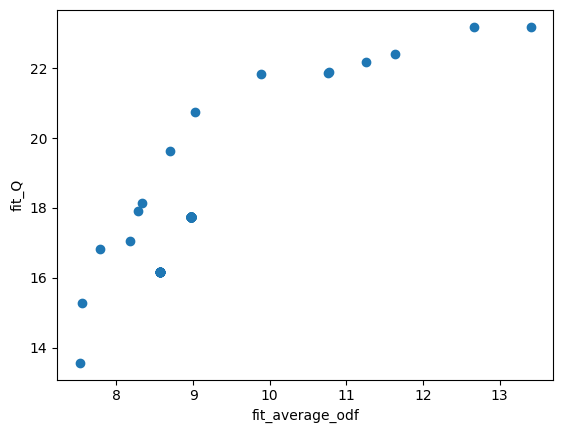

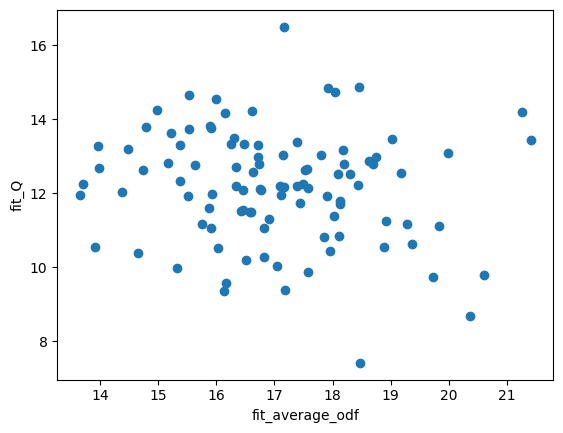

In [101]:
import matplotlib.pyplot as plt

pop = create(amazon_G.nodes, A, conversiones)

print(f"long {len(evolved_pop)}")
fits1 = []
fits2 = []

for ind in evolved_pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))

print(f"fit1 : {fits1}")
print(f"fit2 : {fits2}")

plt.scatter(fits1, fits2)
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()

fits1 = []
fits2 = []

for ind in pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))

plt.scatter(fits1, fits2)
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()


In [53]:
get_comunidades(evolved_pop[0])

[{0, 116, 140, 218, 286, 310, '458993', 64},
 {1, 125, 271, 274, 275, 294, 300, '500861'},
 {2, 32, 439, 468, '521655'},
 {3, '33251'},
 {4, '428737'},
 {'379184', 445, 5},
 {'104481', 6},
 {'238491', 7},
 {'187924', 381, 8},
 {147, '154202', 9},
 {10, 117, '256445'},
 {11, '16457'},
 {12, '123953', 244, 56},
 {13, '460073'},
 {14, 384, 40, '542780'},
 {'126438', 15, 398},
 {16, '270524', 288, 289},
 {'126433', 17, 369, 371, 419, 82},
 {18, 458, '92472'},
 {158, 19, 250, '279830', 358, 424, 443, 66, 68},
 {'114378', 20, 83},
 {21, '409356'},
 {215, 22, '99182'},
 {23, '33710'},
 {'165463', 24, 392},
 {111, 25, '353264'},
 {26, 309, '392463'},
 {27, '512729'},
 {28, '433190', 455},
 {'27890', 29, 304},
 {122, '161737', 30, 465},
 {'309411', 31},
 {226, 33, '374874'},
 {197, 34, '518306'},
 {119, '345901', 35},
 {345, 36, 361, '446298'},
 {'120615', 37},
 {38, '532649'},
 {325, '335987', 39},
 {133, '203272', 41},
 {253, 42, '545994'},
 {'296111', 43},
 {130, '14076', 302, 44},
 {'231620